import requests to install tesseract

In [1]:
import requests

In [2]:
r = requests.get('https://github.com/tesseract-ocr/tesseract/wiki/4.0-with-Docker')

with open('tesseract.txt', 'w') as f:
    f.write(r.text)



In [3]:
! apt-get install tesseract-ocr libtesseract-dev libmagickwand-dev

from IPython.display import HTML, clear_output
clear_output()
print("Done!")

Done!


In [4]:
! pip install pytesseract wand opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 10.7 MB/s eta 0:00:00


In [5]:
from PIL import Image
import pytesseract
import cv2
import numpy as np
from pytesseract import Output
import re

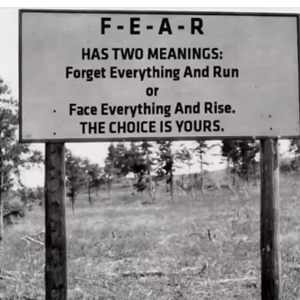

In [7]:
image = Image.open('/content/275311169_1033505353869703_9074658082525820457_n.jpg')
image = image.resize((300,300))
image.save('/content/resized_image.jpg')
image

extracting text from image

In [8]:
custom_config = r' -l eng --oem 3 --psm 6'
text = pytesseract.image_to_string(image, config=custom_config)
print(text)

F-E-A-R
HAS TWO MEANINGS:

; Forget Everything And Run
: or

i : Face Everything And Rise.

._THECHOICEISYOURS.

i See
: ~ : , ~ $
OR aan ae
a AE STAT, Soe as a OA



In [9]:
try:
  text = pytesseract.image_to_string(image, lang='eng')
  characters_to_remove = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
  new_string = text
  for character in characters_to_remove:
    new_string = new_string.replace(character, "")
  print(new_string)
except:
  print('error')

FEAR
HAS TWO MEANINGS
Forget Everything And Run
or

 Face Everything And Rise
THE CHOICE IS YOURS

 



Now We will perform opencv operations to get text from complex images

In [10]:
image = cv2.imread('resized_image.jpg')

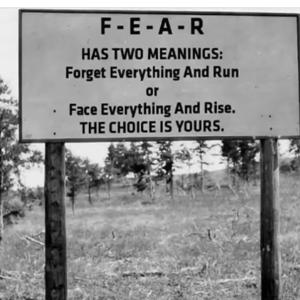

In [11]:
# get grayscale image
def get_grayscale(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = get_grayscale(image)
Image.fromarray(gray)

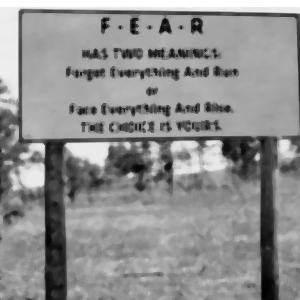

In [12]:
# noise removal
def remove_noise(image):
  return cv2.medianBlur(image, 5)
noise = remove_noise(gray)
Image.fromarray(gray)

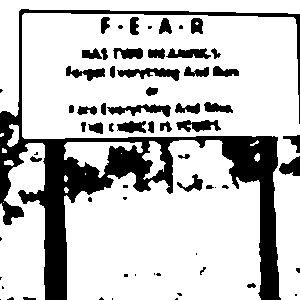

In [13]:
# thresholding
def thresholding(image):
  return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
thresh = thresholding(gray)
Image.fromarray(thresh)